### MFCCs Theory and Implementation:
Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

### Mel Scale:
A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another. Because of how humans perceive sound the MEL scale is a non-linear scale and the distances between the pitches increeses with frequency.

In [27]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
TRAIN_PATH = './'
ipd.Audio(TRAIN_PATH + "download.wav")

In [29]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "download.wav")
#audio file contains the samples 
#array size=frqeuency*(audio file length)
print(audio.shape)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
#44.1Hz is the standard sample rate

(56000,)
Sample rate: 8000Hz
Audio duration: 7.0s


#### Normalisation of Audio
Audio normalization is the process of adjusting the amplitude (i.e., volume) of an audio signal to a standard level. This is typically done to ensure that the audio signal has a consistent volume level across different recordings, tracks, or sections of a larger audio project.

In digital audio, normalization involves scaling the amplitude values of the audio signal so that they fit within a specific range of values, typically from -1 to 1. This is often referred to as peak normalization, as it involves scaling the highest amplitude value in the audio signal to a maximum value of 1.

The primary goal of audio normalization is to prevent clipping or distortion in the audio signal when it is played back or processed. Clipping occurs when the amplitude values of the audio signal exceed the maximum value that can be represented, resulting in distortion or clipping of the waveform. By normalizing the audio signal, the amplitude values are scaled so that they fit within the maximum range, reducing the risk of clipping or distortion.

Audio normalization can also improve the overall listening experience for the audience, as it ensures that the volume level of the audio signal is consistent and comfortable to listen to. This is especially important when working with multiple tracks or recordings that may have different volume levels, as normalization can help to bring them all to a consistent level.

Overall, audio normalization is an important step in the audio production process, as it helps to ensure that the final output has a consistent volume level and is free from distortion or clipping.

In [4]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

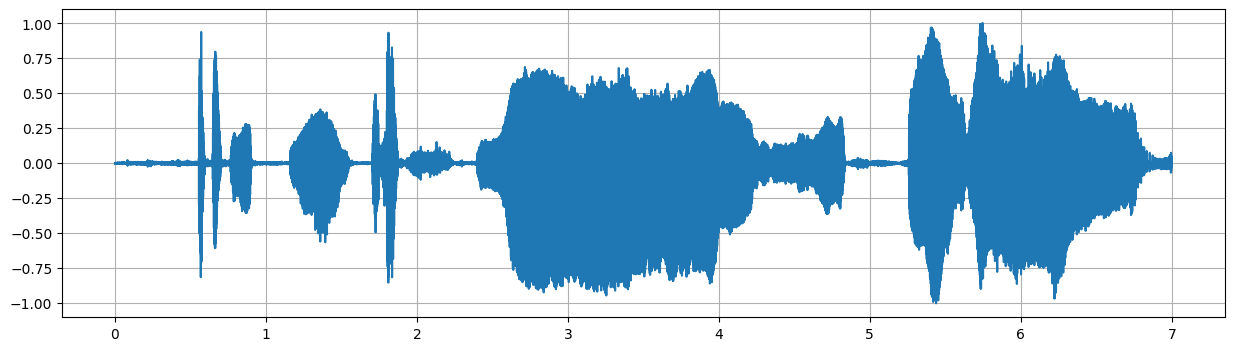

In [30]:
#audio array will be normalised
audio = normalize_audio(audio)
#it sets the figsize to 15icnhes wide and 4 inches tall
plt.figure(figsize=(15,4))
#np.linspace producne x array with equal spacing
#numpy.linspace(start, stop, num=50)
#number of evenly spaced samples
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
#grid is added for better visualisation
plt.grid(True)

#### Frames:
The frames can be thought of as a series of overlapping windows of the original audio signal. The hop size determines the time interval between each frame. Each frame overlaps with the previous one by a certain amount, which is determined by the hop size.

In [32]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms FFT_size=1024, hop_size=10, fs=16KHz, hop_length or window_length =25 ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    #length of each frame is caluclated
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [33]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))
print(audio_framed)

Framed audio shape: (467, 2048)
[[ 0.00219733  0.00299081  0.00289926 ...  0.00018311  0.00289926
   0.00299081]
 [-0.00292978 -0.00155644  0.0004883  ... -0.00238044 -0.00317392
  -0.0069277 ]
 [ 0.00506607  0.00265511  0.00201422 ...  0.00015259  0.00262459
   0.00585955]
 ...
 [ 0.00491348  0.009888    0.01263466 ... -0.01825007 -0.01693777
  -0.01501511]
 [ 0.00274667  0.0003357  -0.00054933 ... -0.002472   -0.00320444
  -0.00317392]
 [-0.00509659 -0.00405896 -0.0029603  ... -0.00015259 -0.00274667
  -0.00387585]]


In [34]:
print("First frame:")
audio_framed[1]

First frame:


array([-0.00292978, -0.00155644,  0.0004883 , ..., -0.00238044,
       -0.00317392, -0.0069277 ])

In [35]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([-0.00509659, -0.00405896, -0.0029603 , ..., -0.00015259,
       -0.00274667, -0.00387585])

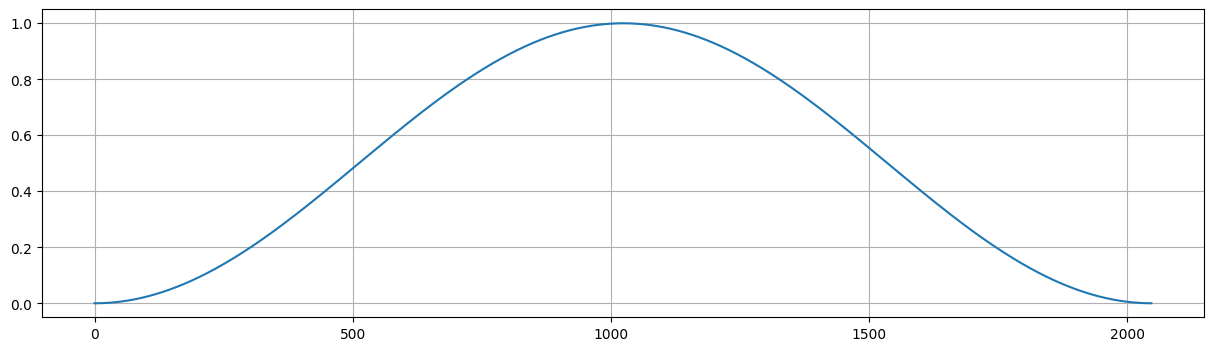

In [36]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4)) #figure (4,4), (5,5) or (6,6)
plt.plot(window)
plt.grid(True)

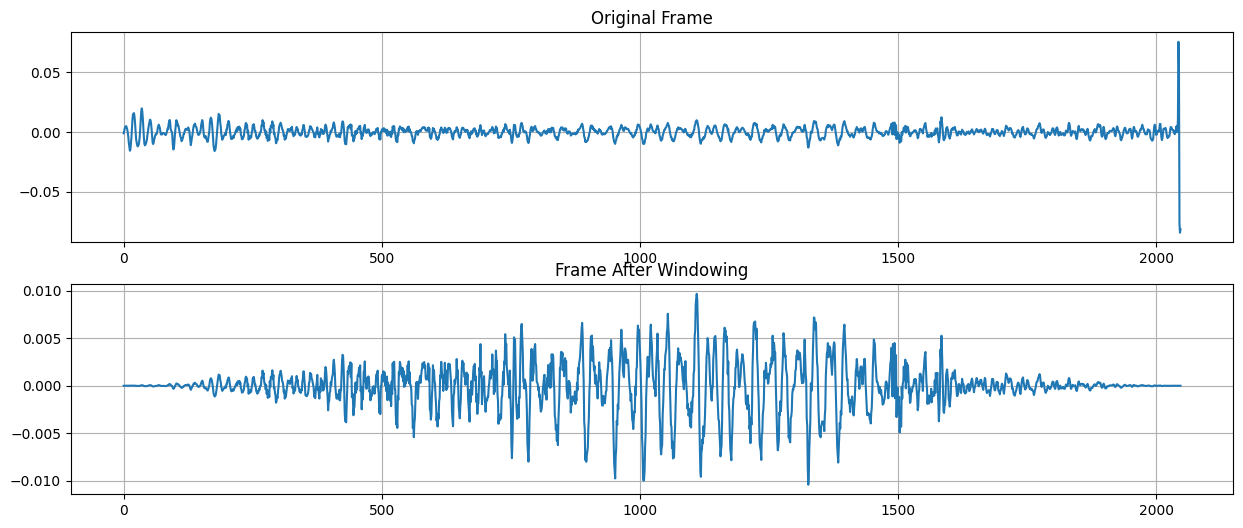

In [37]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [38]:
print(audio_win.shape)
audio_winT = np.transpose(audio_win)
print(audio_winT.shape)
audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
print(audio_fft.shape[1])
# In the above line of code, fft.fft() is used to compute the Fast Fourier Transform (FFT) of each frame after applying the window function to it. The FFT is a mathematical algorithm that transforms a time-domain signal into its frequency-domain representation. It is commonly used in signal processing and is especially useful for analyzing periodic signals.

# The parameters of the fft.fft() function used in the code are:

# audio_winT[:, n]: This is the input signal for which the FFT is computed. It is a 1D array of length FFT_size that represents the current frame after applying the window function to it. audio_winT is the transpose of the audio_win array obtained from framing the audio, and n is the index of the current frame.
# axis=0: This parameter specifies the axis along which the FFT is computed. In this case, it is set to 0 to compute the FFT along the rows of the audio_winT array, which correspond to the samples of the input signal.
# [:audio_fft.shape[0]]: This is used to truncate the FFT output to half of the FFT size. The FFT returns a complex array of length FFT_size, but since the FFT of a real-valued signal is symmetric, only the first half of the FFT output contains unique information. Therefore, the output is truncated to only include the first FFT_size/2 + 1 elements, which correspond to the positive frequencies. The resulting array is assigned to the n-th column of audio_fft using the syntax audio_fft[:, n].
for n in range(audio_fft.shape[1]):
     #we are selecting the n th frame column and all rows will be selected
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
audio_fft = np.transpose(audio_fft)

(467, 2048)
(2048, 467)
467


#### Signal Power
This code calculates the power spectrum of the audio frames obtained after applying the window function and taking the Fourier Transform of each frame. The power spectrum is the squared magnitude of the Fourier Transform of a signal, and it represents the distribution of power of different frequencies in the signal.

Here, np.abs is used to calculate the magnitude of the complex-valued Fourier coefficients obtained after applying the Fourier Transform. Then, the result is squared using np.square to get the power spectrum. The resulting array audio_power has the shape (num_frames, num_FFT_points/2 + 1), where num_frames is the number of frames in the audio and num_FFT_points is the number of points used for the FFT. The +1 in the second dimension is because the FFT returns a symmetric array and the second half is redundant, so only half of the FFT output is stored.

In [39]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(467, 1025)


#### MEL-Spaced FilterBank
Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band

In [40]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 4000.0


#### Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

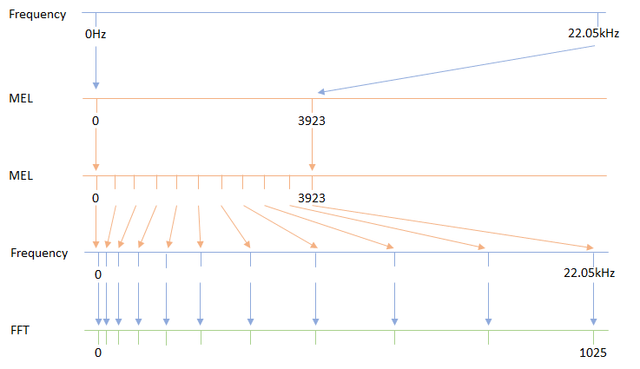

In [41]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

#### Filter Points:
Convert the filterbank edges to the MEL space using the freq_to_mel function. This converts the frequency values to corresponding MEL scale values.

Create an array of mel_filter_num + 2 equally spaced points between the two MEL frequencies. The +2 is because we need one more point than the number of filters we want, to specify the start and end frequencies.

Convert the array of MEL frequencies back to the frequency scale using the met_to_freq function. This gives us the actual frequencies that correspond to the equally spaced MEL values.

Normalize the array of frequencies so that they are scaled from 0 to FFT_size/2. This is done by dividing each frequency value by the Nyquist frequency (sample_rate/2) and then multiplying by FFT_size.

Choose the corresponding FFT values for each filter frequency by rounding the normalized frequencies to the nearest integer index of the FFT array. These indices specify the frequency bins that correspond to the filterbank frequencies.

Overall, this process creates an array of filterbank frequencies that are equally spaced in MEL scale, but not equally spaced in frequency scale. The normalization and rounding steps map these frequencies to specific frequency bins in the FFT, which we will use to compute the filterbank energies in the next step.

In [42]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    #it first tries to find fmin_mel and fmax_mel as per the mel scale.
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    #it will create equal sized space mel_filter_num filters in b/w the fmin and fmax
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    #the mel scale frequencies are again rolled back to normal frequencies
    freqs = met_to_freq(mels)
    #this function is returning two arrays 
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [43]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 2146.06452750619


array([  0,   6,  13,  22,  32,  44,  59,  76,  97, 121, 151, 185])

#### Triangular Filter Caluclation
Using the filter points obtained from the previous step, we can construct a triangular filterbank. Each filter in the filterbank is triangular in shape, and is defined by three points - the start point, the peak point, and the end point. The peak point is always set to the center frequency of the triangular filter.
The triangular filters are created using the following steps:
Initialize an array of zeros of size (num_filters, int(FFT_size/2 + 1)) to store the filterbank.
Loop over each filter (from 0 to num_filters-1).
Calculate the start, center, and end points of the current triangular filter using the filter_points array obtained in the previous step.
Loop over each frequency bin (from 0 to int(FFT_size/2)).
If the current frequency bin is less than the start point of the filter or greater than the end point of the filter, set the filterbank value to 0 for that bin.
If the current frequency bin is between the start and end points of the filter, set the filterbank value to a triangular weighting that varies linearly from 0 to 1 between the start and peak points, and varies linearly from 1 to 0 between the peak and end points.
Normalize each filter so that the area under the curve is equal to 1. This is done to ensure that the energy in the signal is preserved after filtering.

The function get_filters takes in two arguments, filter_points and FFT_size, and returns a matrix filters of size (num_filters, FFT_size/2+1) where num_filters is the number of filter banks, and FFT_size is the length of the FFT.

In the for loop, each triangular filter bank is created by setting the values in the filters matrix. The filter banks are created by using two linspace functions that linearly interpolate between 0 and 1 and between 1 and 0, respectively. These linearly interpolated values are used to fill the appropriate sections of the filters matrix to create a triangular filter bank.

Specifically, the loop iterates over the range of num_filters-2 and for each iteration, the filter bank is created by setting the values between the filter_points[n] and filter_points[n+1] indices to the linearly interpolated values between 0 and 1, and the values between filter_points[n+1] and filter_points[n+2] to the linearly interpolated values between 1 and 0. This creates a triangular-shaped filter bank that spans a certain frequency range. The resulting filters matrix contains all of the triangular filter banks

In [44]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

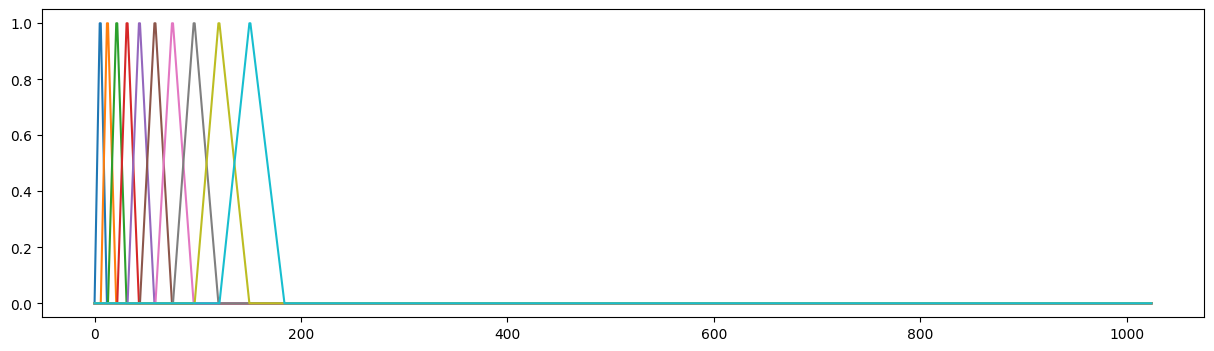

In [19]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

#### Normalisation of Filter Bank
Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.
The mel_freqs variable contains the center frequencies of each filter in the mel-scale. We use these frequencies to calculate the bandwidth of each filter.

We then calculate the normalization factor enorm by taking the reciprocal of the bandwidth and scaling it by a factor of 2.0. We slice mel_freqs to exclude the first and last elements as they are not used to calculate filter bandwidths.

Finally, we multiply each row of the filters array with the corresponding element in the enorm array. The [:, np.newaxis] syntax is used to ensure that the broadcasting of the normalization factor is done along the second axis of the filters array, which corresponds to the frequency bins.

Multiplying the filterbank by the normalization factor ensures that the energy of each filter is equalized, preventing the filters with larger bandwidths from having lower amplitudes.
Here, enorm is a one-dimensional array, and filters is a two-dimensional array, so to perform element-wise multiplication between enorm and each row of filters, we need to add a new dimension to enorm. The [:, np.newaxis] is equivalent to [:, None], where : represents all rows of enorm and np.newaxis is added to indicate that we are adding a new axis along the second dimension. This results in the shape of enorm changing from (num_filters,) to (num_filters, 1), allowing it to be broadcasted with filters during the element-wise multiplication.

In [45]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
print(enorm)
filters *= enorm[:, np.newaxis]

[0.00690597 0.00580822 0.00488496 0.00410846 0.00345539 0.00290613
 0.00244418 0.00205566 0.0017289  0.00145408]


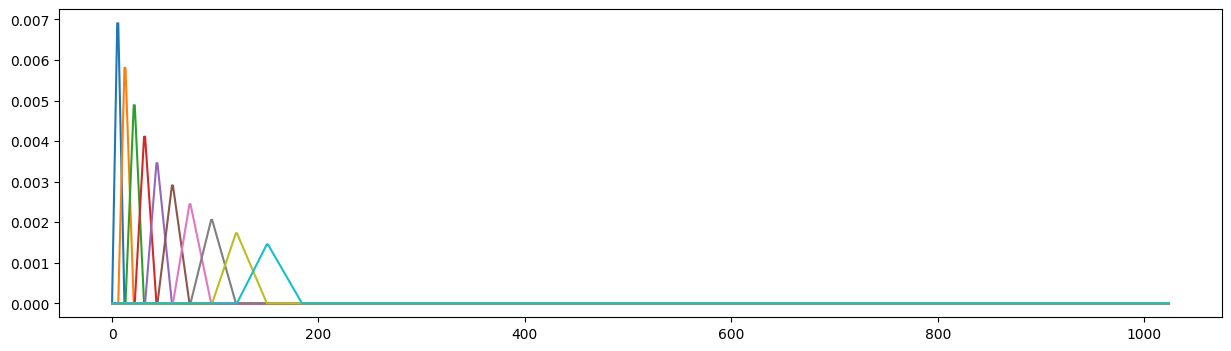

In [21]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

#### Filtering The Audio Signal
The first operation applies the filters to the audio signal using matrix multiplication and transpose operations, resulting in a filtered audio signal audio_filtered. This operation can be expressed as the dot product of filters and the transpose of audio_power using the np.dot() and np.transpose() functions respectively.

The second operation computes the logarithmic power of the filtered audio signal using the decibel scale, which is a commonly used scale for measuring the intensity of sound. This operation can be expressed as the element-wise logarithm (base 10) of audio_filtered multiplied by 10.0, using the np.log10() and * operators respectively, and assigned to a new variable audio_log.

Finally, the code outputs the shape of the resulting filtered and logarithmic audio signal using the shape attribute of the audio_log NumPy array. The shape attribute returns a tuple representing the dimensions of the array, where the first value corresponds to the number of rows (or samples) and the second value corresponds to the number of columns (or channels).

In [22]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 467)

#### Generating the Cepstral Coefficients
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). 
We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal.
This function implements the Discrete Cosine Transform (DCT) to generate a set of basis functions for use in signal processing.

The input arguments to the function are:

dct_filter_num: an integer specifying the number of basis functions to generate.
filter_len: an integer specifying the length of each basis function.
The function creates an empty numpy array with dimensions (dct_filter_num, filter_len) to store the basis functions. The first basis function is a constant function with all elements set to 1/sqrt(filter_len). The remaining basis functions are generated using the DCT formula, which involves computing cosine functions with increasing frequencies.
This line of code generates a numpy array called samples, which contains a sequence of angles in radians that are used to compute the cosine functions for the DCT basis.

The np.arange function generates a sequence of evenly spaced integers from 1 up to (but not including) 2 * filter_len, with a step size of 2. This creates a sequence of odd integers, which are used to generate the cosine functions for the DCT.

Multiplying this sequence by np.pi / (2.0 * filter_len) converts the integers to angles in radians that range from 0 to pi/2. The resulting sequence of angles corresponds to equally spaced points on a half-cycle of a cosine function, which is used to generate the basis functions for the DCT.

The DCT is widely used in signal processing and data compression applications. It transforms a signal from the time domain to the frequency domain, revealing the frequency components present in the signal. The basis functions generated by this function can be used to represent signals in the frequency domain, and can be used to compress signals by selecting a subset of basis functions that capture the most important frequency components.

DCT Formula
C(u,v)=[1/sqrt(n) if u=0)
else C(u,v)=sqrt(2/N)*(cos(((2v+1)*(pi*u))/2*N))

In [46]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [47]:

dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 467)

In [48]:
cepstral_coefficents[:, 0]

array([-1.14854580e+02, -1.98513635e+01, -1.30154067e+01,  4.43247151e+00,
        3.03167496e+00,  2.02710988e+00, -1.69225802e+00,  3.09678409e-01,
       -6.01493550e-01, -1.37317137e+00,  1.29451636e-13,  1.37317137e+00,
        6.01493550e-01, -3.09678409e-01,  1.69225802e+00, -2.02710988e+00,
       -3.03167496e+00, -4.43247151e+00,  1.30154067e+01,  1.98513635e+01,
        1.62428905e+02,  1.98513635e+01,  1.30154067e+01, -4.43247151e+00,
       -3.03167496e+00, -2.02710988e+00,  1.69225802e+00, -3.09678409e-01,
        6.01493550e-01,  1.37317137e+00, -1.12324958e-14, -1.37317137e+00,
       -6.01493550e-01,  3.09678409e-01, -1.69225802e+00,  2.02710988e+00,
        3.03167496e+00,  4.43247151e+00, -1.30154067e+01, -1.98513635e+01])

The first plot displays an audio signal as a time-domain waveform. The x-axis represents time in seconds, and the y-axis represents the amplitude of the audio signal. The np.linspace(0, len(audio) / sample_rate, num=len(audio)) function generates a linearly spaced array of time values based on the length of the audio signal (len(audio)) and the sample rate (sample_rate).

The second plot displays the cepstral coefficients of the audio signal as a spectrogram. The cepstral_coefficents variable is likely a matrix of cepstral coefficients computed using a signal processing technique called cepstral analysis. The imshow function is used to display the matrix as an image, where the x-axis represents time and the y-axis represents frequency. The aspect='auto' argument ensures that the aspect ratio of the image is adjusted to match the dimensions of the matrix, and the origin='lower' argument sets the origin of the image to the lower-left corner.

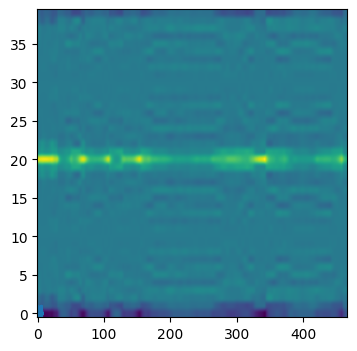

In [50]:
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');